In [ ]:
map_yaml = "map/atc/localization_grid.yaml"
# map_image = "map/atc/atc-occu.png"
map_image = "map/atc/atc-occu-black.png"
traj_csv = "dataset/atc/1024.csv"
free_pixel_threshold = 128

In [2]:
## load map and yaml configs
import yaml
import numpy as np
from PIL import Image
from map_sdf import MapSDF

with open(map_yaml, "r") as f:
    yaml_data = yaml.safe_load(f)
resolution = float(yaml_data["resolution"])
origin = yaml_data["origin"]
origin_x, origin_y = float(origin[0]), float(origin[1])
origin_at_bottom_left = True

gray_map = np.array(Image.open(map_image).convert("L"))
H, W = gray_map.shape # H=1200, W=2800

In [3]:
# load trajectories
import pandas as pd

traj_df = pd.read_csv(
    traj_csv,
    header=None,
    names=["time", "person_id", "x", "y", "speed", "orientation"],
    dtype={
        "time": float,
        "person_id": int,
        "x": float,
        "y": float,
        "speed": float,
        "orientation": float,
    },
)

# define the Signed Distance Function (SDF) for the map
sdf = MapSDF(gray_map, resolution, origin_x, origin_y,
             origin_at_bottom_left=True, free_pixel_threshold=128)


# convert to pixel coordinates
traj_df["u"], traj_df["v"] = sdf.world_to_pixel(traj_df["x"].values, traj_df["y"].values)

In [4]:
# check collisions with dataset trajectory with the map
inside = (
    (traj_df["u"] >= 0) & (traj_df["u"] < W) &
    (traj_df["v"] >= 0) & (traj_df["v"] < H)
)
traj_df["collision"] = False
# inside-map pixels
idx = inside.values
traj_df.loc[idx, "collision"] = (
    gray_map[traj_df.loc[idx, "v"], traj_df.loc[idx, "u"]] < free_pixel_threshold
)

# --- which person IDs collide ---
collided_ids = traj_df.loc[traj_df["collision"], "person_id"].unique()
print(f"{len(collided_ids)} person_ids have collisions")


0 person_ids have collisions


In [5]:
traj_df

,time,person_id,x,y,speed,orientation,u,v,collision
0,1.351038e+09,9190600,-37.262,-3.161,0.903,2.798,455,462,False
1,1.351038e+09,9190600,-38.235,-3.175,0.924,3.024,435,462,False
2,1.351038e+09,9190600,-39.225,-2.888,0.777,2.775,415,457,False
3,1.351038e+09,9190600,-40.104,-2.444,0.857,2.625,398,448,False
4,1.351038e+09,9190700,25.949,-14.777,0.866,2.584,1719,695,False
...,...,...,...,...,...,...,...,...,...
717870,1.351078e+09,20271200,44.813,-18.948,0.931,-0.402,2096,778,False
717871,1.351078e+09,20271200,45.511,-18.748,0.606,0.247,2110,774,False
717872,1.351078e+09,20271200,46.082,-18.453,0.623,0.553,2122,768,False
717873,1.351078e+09,20271200,46.590,-17.794,0.953,1.043,2132,755,False


Text(0.5, 1.0, 'Signed Distance Field')

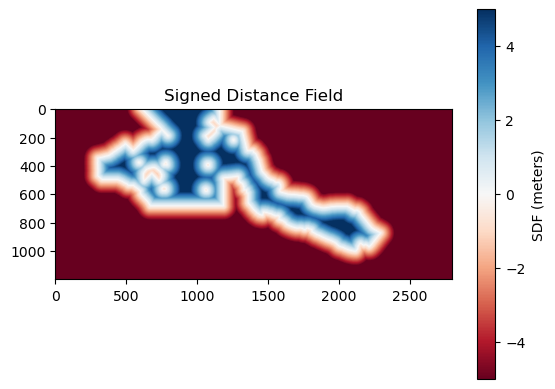

In [17]:
######## getting SDF values along trajectories ########

# Query along trajectories (trajectory in meters and return SDF in meters)
traj_df["sdf"] = sdf.query_world(traj_df["x"].values, traj_df["y"].values, meters=True)
# Query along trajectorys (trajectory in meters and return SDF in pixels)
# traj_df["sdf"] = sdf.query_world(traj_df["x"].values, traj_df["y"].values, meters=False)
# Query along trajectorys (trajectory in pixels and return SDF in meters)
# traj_df["sdf"] = sdf.query_pixel(traj_df["u"].values, traj_df["v"].values, meters=True)
# Query along trajectories (trajectory in pixels and return SDF in pixels)
# traj_df["sdf"] = sdf.query_pixel(traj_df["u"].values, traj_df["v"].values, meters=False)

# Collision = negative SDF
traj_df["collision"] = traj_df["sdf"] < 0

#### Visualize the SDF field in meters
import matplotlib.pyplot as plt
plt.imshow(sdf.sdf_meters, cmap="RdBu", vmin=-5, vmax=5)
plt.colorbar(label="SDF (meters)")
plt.title("Signed Distance Field")


#### Visualize the SDF field in pixelss
# plt.imshow(sdf.sdf_pixels, cmap="RdBu", vmin=-100, vmax=100) # resolution=0.05m/pixel, so 20 pixels = 1m
# plt.colorbar(label="SDF (pixels)")
# plt.title("Signed Distance Field (pixels)")